In [57]:
import torch
from torch.autograd import grad
from torch.optim.lr_scheduler import ReduceLROnPlateau
import sys
import datetime
sys.path.append('..')
from src import train, utils
from src import calculus as calc
import src.data.cube_domain as cb
import src.models.mlp_model as mm
from typing import Tuple

In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TRAIN_TEMP_SAVE_PATH = './most_eff_model.pt'
NU = 1 / 200
RE = 1 / NU
T_MAX = 1
L_BOUNDS = [-0.5, -0.5]
U_BOUNDS = [0.5, 0.5]
A = 0.3  # used during training to select A percentage of points with smallest detection metric

In [60]:
def pde_res(model: torch.nn.Module, input: torch.Tensor) -> Tuple[torch.Tensor]:
    _, _, u, v, u_x, u_y, v_x, v_y, u_xx, u_yy, v_xx, v_yy, p_x, p_y = calc.compute_derivatives_ns(model, input)
    res_a = u * u_x + v * u_y + p_x - NU * (u_xx + u_yy)
    res_b = u * v_x + v * v_y + p_y - NU * (v_xx + v_yy)
    return res_a, res_b


def SDF_weights(x: torch.Tensor) -> torch.Tensor:
    return 1.0 - 2.0 * torch.abs(x[:, 0:1])


def loss_fn(model: torch.nn.Module, domain: cb.CubeDomain):
    # PDE loss
    pde_input = domain.interior.requires_grad_(True)
    res_a, res_b = pde_res(model, pde_input)
    pde_loss = torch.mean(res_a**2) + torch.mean(res_b**2)

    # Top loss
    top_input = domain.sides[1][1].requires_grad_(True)
    psi_top = model(top_input)[:, 0]
    psi_top_grad = grad(psi_top, top_input, torch.ones_like(psi_top), create_graph=True)[0]
    u_top, v_top = - psi_top_grad[:, 1:2], psi_top_grad[:, 0:1]
    top_weigths = SDF_weights(top_input)
    top_loss = torch.sum(top_weigths * ((u_top - 1)**2 + v_top**2)) / torch.sum(top_weigths)

    # Side loss
    side_input = torch.cat([domain.sides[0][0], domain.sides[0][1], domain.sides[1][0]], dim=0).requires_grad_(True)
    psi_sides = model(side_input)[:, 0]
    psi_sides_grad = grad(psi_sides, side_input, torch.ones_like(psi_sides), create_graph=True)[0]
    u_side, v_side = - psi_sides_grad[:, 1:2], psi_sides_grad[:, 0:1]
    side_loss = torch.mean(u_side**2 + v_side**2)

    return [pde_loss, 5 * top_loss, side_loss]

In [61]:
domain_ctx = cb.CubeContext(
    l_bounds=L_BOUNDS,
    u_bounds=U_BOUNDS,
    dim=2,
    device=device,
    int_sampling='Latin',
    N_int=10_000,
    N_sides=[(1000, 1000), (1000, 2000)],
)

domain = cb.CubeDomain(domain_ctx)

In [ ]:
model_ctx = mm.ModelContext(
    input_dim=2,
    output_dim=2,
    layer = [32, 32, 32, 32, 32],
    u_bounds=U_BOUNDS,
    l_bounds=L_BOUNDS,
    fourier_features=False,
    fourier_frequencies=128,
    fourier_scale=3.0
)

model = mm.MLPModel(model_ctx).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

In [ ]:
train_ctx = train.TrainingContext(
    model=model,
    optimizer=optimizer,
    domain=domain,
    loss_fn=loss_fn,
    resample=False,
    epochs=20_000
)

domain.generate_points()
total_loss_values, component_loss_values = train.simple_train(train_ctx)

Loss at epoch 1 is: 4.748869895935059. 
Loss at epoch 100 is: 0.18583548069000244. 
Loss at epoch 200 is: 0.09151224046945572. 
Loss at epoch 300 is: 0.04903494566679001. 
Loss at epoch 400 is: 0.0331878699362278. 
Loss at epoch 500 is: 0.02908249944448471. 
Loss at epoch 600 is: 0.02801075018942356. 
Loss at epoch 700 is: 0.027051545679569244. 
Loss at epoch 800 is: 0.026640400290489197. 
Loss at epoch 900 is: 0.02655845135450363. 
Loss at epoch 1000 is: 0.026118114590644836. 
Loss at epoch 1100 is: 0.025957806035876274. 
Loss at epoch 1200 is: 0.025734199211001396. 
Loss at epoch 1300 is: 0.03284104913473129. 
Loss at epoch 1400 is: 0.02541486546397209. 
Loss at epoch 1500 is: 0.025257598608732224. 
Loss at epoch 1600 is: 0.025180285796523094. 
Loss at epoch 1700 is: 0.024981990456581116. 
Loss at epoch 1800 is: 0.027452796697616577. 
Loss at epoch 1900 is: 0.024723045527935028. 
Loss at epoch 2000 is: 0.024588825181126595. 
Loss at epoch 2100 is: 0.024478120729327202. 
Loss at epoch

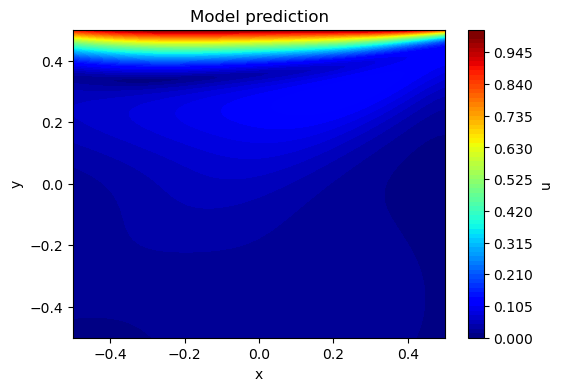

In [64]:
plot_ctx = utils.PlotContext(
    l_bounds=L_BOUNDS,
    u_bounds=U_BOUNDS,
    function_names = ['u'],
    titles= ['Model prediction'],
    device=device,
    vmin=0,
    vmax=1,
    patches=[],
    N = 100
)

def velocity(x: torch.Tensor) -> torch.Tensor:
    x.requires_grad_(True)
    psi = model(x)[:, 0]
    psi_grad = grad(psi, x, torch.ones_like(psi), create_graph=True)[0]
    
    return torch.norm(psi_grad, dim=1, p=2)

utils.plot_function_on_2d_cube([velocity], plot_ctx)